In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.classification import log_loss
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

from scipy.sparse import hstack
import seaborn as sns

import xgboost as xgb

from prettytable import PrettyTable

In [2]:
#reading train, test and CV data
train = pd.read_csv('nlp_features_train.csv');
test  = pd.read_csv('nlp_features_test.csv');
cv    = pd.read_csv('nlp_features_cv.csv');

In [3]:
#to avoid decoding problem
def convert_str(df):
    df['question1'] = df['question1'].apply(lambda x: str(x))
    df['question2'] = df['question2'].apply(lambda x: str(x))
    return df

In [4]:
train = convert_str(train);
train.head()

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1Len,q2Len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,394633,185833,3212,one amp equals how many watts,what is the difference between amps watts and...,2,2,30,53,7,...,0.199996,0.0,0.0,3.0,7.5,42,42,37,50,0.225806
1,339905,467594,467595,what is dmart own pentagon retail model,what is dmart own triangle retail model,1,1,40,40,8,...,1.999933,1.0,1.0,0.0,7.0,87,79,87,88,0.439024
2,131352,24396,146824,what is a meaning of life,what is the meaning of life,5,5,26,30,7,...,1.249969,1.0,1.0,0.0,6.0,96,88,91,85,0.444444
3,43077,77539,77540,how can i unlock my iphone if i forget the pas...,how can i unlock an iphone 6 plus without a pa...,1,1,52,53,12,...,0.999983,1.0,1.0,0.0,11.0,79,64,76,75,0.320755
4,221419,294898,97822,which are the best online courses to learn pyt...,what is the best online resources to learn pyt...,1,3,111,50,24,...,0.666659,0.0,0.0,11.0,14.5,78,46,52,84,0.372549


In [5]:
test  = convert_str(test);
cv = convert_str(cv);

### Featurizing question1 and question2 using tfidf wtd w2v
 

In [6]:
# merge texts
questions = list(train['question1']) + list(train['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

<h4>Featurizing on train data</h4>

In [7]:
nlp = spacy.load('en_core_web_lg')

train_vecs1 = []
for qu1 in tqdm(list(train['question1'])):
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    train_vecs1.append(mean_vec1)
    
train['q1_feats_m'] = list(train_vecs1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 198102/198102 [31:13<00:00, 105.74it/s]


In [8]:
train_vecs2 = []
for qu2 in tqdm(list(train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    train_vecs2.append(mean_vec2)
train['q2_feats_m'] = list(train_vecs2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 198102/198102 [29:36<00:00, 111.52it/s]


<h4>Featurizing on test data</h4>

In [9]:
test_vecs1 = []

for qu1 in tqdm(list(test['question1'])):
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word in doc1:
        # word2vec
        vec1 = word.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    test_vecs1.append(mean_vec1)
test['q1_feats_m'] = list(test_vecs1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 121287/121287 [18:02<00:00, 106.84it/s]


In [10]:
test_vecs2 = []
for qu2 in tqdm(list(test['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    test_vecs2.append(mean_vec2)
test['q2_feats_m'] = list(test_vecs2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 121287/121287 [18:40<00:00, 108.20it/s]


<h4>Featurizing on cv data</h4>

In [11]:
cv_vecs1 = []

for qu1 in tqdm(list(cv['question1'])):
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word in doc1:
        # word2vec
        vec1 = word.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    cv_vecs1.append(mean_vec1)
cv['q1_feats_m'] = list(cv_vecs1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 84901/84901 [13:11<00:00, 107.29it/s]


In [12]:
cv_vecs2 = []
for qu2 in tqdm(list(cv['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    cv_vecs2.append(mean_vec2)
cv['q2_feats_m'] = list(cv_vecs2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 84901/84901 [13:11<00:00, 107.27it/s]


## Merging vectorized features

### merging training data

In [13]:
#creating seperate DF for w2v of question 1 and 2
df_q1 = pd.DataFrame(train.q1_feats_m.values.tolist(), index= train.index)
df_q2 = pd.DataFrame(train.q2_feats_m.values.tolist(), index=train.index)
train = train.drop(['q1_feats_m', 'q2_feats_m'], axis=1)

In [14]:
#putting id of train into both DF
df_q1['id'] = train['id']
df_q2['id'] = train['id']

In [15]:
df = df_q1.merge(df_q2, on='id', how='left')
df_train = train.merge(df, on='id', how='left')
df_train.head()

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1Len,q2Len,q1_n_words,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,394633,185833,3212,one amp equals how many watts,what is the difference between amps watts and...,2,2,30,53,7,...,-2.693894,-14.901176,5.128220,5.728596,-7.502452,7.165957,4.377521,-7.439754,3.364170,-5.598648
1,339905,467594,467595,what is dmart own pentagon retail model,what is dmart own triangle retail model,1,1,40,40,8,...,-7.720754,8.802047,10.015510,11.371371,-7.907477,-8.813922,-8.071901,-2.865460,7.421386,7.570686
2,131352,24396,146824,what is a meaning of life,what is the meaning of life,5,5,26,30,7,...,-6.257824,-3.298769,-2.796339,-3.863447,1.112255,3.300804,-3.501771,1.544473,-0.689151,-4.159499
3,43077,77539,77540,how can i unlock my iphone if i forget the pas...,how can i unlock an iphone 6 plus without a pa...,1,1,52,53,12,...,-16.185374,8.990575,-4.163904,2.844192,12.438261,0.954519,-7.808202,10.853596,-7.612176,11.641490
4,221419,294898,97822,which are the best online courses to learn pyt...,what is the best online resources to learn pyt...,1,3,111,50,24,...,-3.179064,-4.292604,-10.911485,2.174121,5.454123,3.782682,1.179962,-8.992926,-3.421847,10.716233


In [16]:
#saving features in excel
df_train.to_csv('final_features_avg_w2v_train.csv')

### merging CV data

In [17]:
df_q1 = pd.DataFrame(cv.q1_feats_m.values.tolist(), index=cv.index)
df_q2 = pd.DataFrame(cv.q2_feats_m.values.tolist(), index=cv.index)
cv = cv.drop(['q1_feats_m', 'q2_feats_m'], axis=1)

In [18]:
df_q1['id'] = cv['id']
df_q2['id'] = cv['id']

In [19]:
df = df_q1.merge(df_q2, on='id', how='left')
df_cv = cv.merge(df, on='id', how='left')
df_cv.head()

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1Len,q2Len,q1_n_words,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,204827,307828,307829,how does distilled water differ from spring wa...,why is distilled water better than spring water,1,2,50,48,9,...,-8.180585,-7.685680,3.621565,-13.419825,-2.762812,-3.844124,-14.450468,-15.873128,0.851618,-3.716519
1,35012,64051,64052,how do i quit watching porn and focus in life,why did you quit watching porn,1,1,46,31,11,...,6.130694,-1.629369,-8.314602,-3.119525,5.991219,3.410337,-2.202939,0.728919,0.274184,2.286874
2,400122,313281,533461,why do you use twitter but not facebook,why do you not use twitter,1,1,41,27,10,...,-5.504728,0.277276,1.687869,1.828024,6.687006,0.194949,-5.541298,-6.936907,1.214309,10.824985
3,285605,406045,406046,is a square also a rhombus if not why,can a rectangle also be a rhombus,1,1,40,34,12,...,5.901763,11.392240,-9.735606,-9.001246,1.560969,-2.537093,-11.022644,1.669967,15.322397,13.807467
4,67164,116284,116285,are humans suppose to have as much sex everyd...,science of everyday life what are the greates...,1,1,119,72,26,...,-17.865235,3.007038,-2.782918,-12.177808,0.242313,8.978230,2.287433,-4.196572,-6.972139,-2.101596


In [20]:
#saving features in excel
df_cv.to_csv('final_features_avg_w2v_cv.csv')

### merging test data

In [21]:
df_q1 = pd.DataFrame(test.q1_feats_m.values.tolist(), index=test.index)
df_q2 = pd.DataFrame(test.q2_feats_m.values.tolist(), index=test.index)
test = test.drop(['q1_feats_m', 'q2_feats_m'], axis=1)

In [22]:
df_q1['id'] = test['id']
df_q2['id'] = test['id']

In [23]:
df = df_q1.merge(df_q2, on='id', how='left')
df_test = test.merge(df, on='id', how='left')
df_test.head()

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1Len,q2Len,q1_n_words,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,237030,33086,348102,how can i stop playing video games,should i stop playing video games with my child,1,1,35,48,8,...,-8.693587,-1.245995,-11.200996,5.140328,15.107444,9.483084,-2.574097,-5.503761,2.910798,8.713992
1,247341,73272,8624,who is better donald trump or hillary clinton,why is hillary clinton a better choice than do...,8,3,46,57,9,...,1.782307,8.825999,-13.432579,-4.531607,11.209176,-0.258310,-1.394302,-13.921498,-0.467377,3.786713
2,246425,359482,359483,what do you think is the chance that sometime ...,do you think there will be another world war n...,1,1,139,77,31,...,-22.330916,8.570810,-13.660988,0.155858,0.659431,12.150103,-13.746003,10.659862,-1.799110,14.517045
3,306985,1357,47020,why are so many questions posted to quora that...,why do people write questions on quora that co...,6,7,86,86,17,...,-16.908830,-3.946437,-0.007691,2.162127,19.265175,-11.164900,-6.002581,-8.888336,11.608599,22.519480
4,225863,334315,334316,can there even be a movie ever rated 10 10 on ...,what are your 10 10 movies,1,1,51,27,13,...,-4.727139,2.578511,-2.767348,1.340994,-0.614293,-2.142189,-1.558200,-6.277861,3.927348,0.964829


In [24]:
df_test.to_csv('final_features_avg_w2v_test.csv')

# Modeling


### Seperating input and output data

In [3]:
train_y = df_train['is_duplicate'].values;
train_X = df_train.loc[:, df_train.columns != 'is_duplicate']

test_y = df_test['is_duplicate'].values;
test_X = df_test.loc[:, df_test.columns != 'is_duplicate']

cv_y = df_cv['is_duplicate']
cv_X = df_cv.loc[:, df_cv.columns != 'is_duplicate']

In [4]:
#dropping 'question1', 'id', 'question2', 'qid1', 'qid2' columns
train_X = train_X.drop(['question1', 'id', 'question2', 'qid1', 'qid2'], axis=1)
test_X = test_X.drop(['question1', 'id', 'question2',  'qid1', 'qid2'], axis=1)
cv_X = cv_X.drop(['question1', 'id', 'question2',  'qid1', 'qid2'], axis=1)

### Finding distribution of output data

In [37]:
train_dist = Counter(train_y)
train_counts = train_y.shape[0]
print(f"Distribution in train data: class 0 => {train_dist[0]/train_counts}, class 1 => {train_dist[1]/train_counts}")

test_dist = Counter(test_y)
test_counts = test_y.shape[0]
print(f"Distribution in test data: class 0 => {test_dist[0]/test_counts}, class 1 => {test_dist[1]/test_counts}")

cv_dist = Counter(cv_y)
cv_counts = cv_y.shape[0]
print(f"Distribution in cv data: class 0 => {cv_dist[0]/cv_counts}, class 1 => {cv_dist[1]/cv_counts}")

Distribution in train data: class 0 => 0.6315382984523125, class 1 => 0.36846170154768754
Distribution in test data: class 0 => 0.6296800151706283, class 1 => 0.3703199848293717
Distribution in cv data: class 0 => 0.6306875066253637, class 1 => 0.36931249337463634


### defining function to plot confusion matrix, Precission matrix, Recall matrix

In [5]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    #finding recall matrix
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    #finding precision matrix
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]

    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    ax = sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"fontsize":15})
    ax.set_ylim(2.0,0)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    ax = sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"fontsize":15})
    ax.set_ylim(2.0, 0)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    ax = sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws={"fontsize":15})
    ax.set_ylim(2.0, 0)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Building Random Model  (Finding worst case log-loss)

Log loss on Test Data using Random Model: 0.8838083513668935


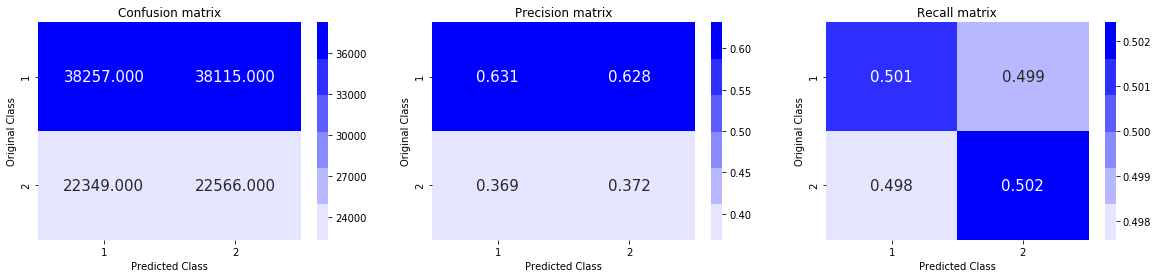

In [44]:
test_len = len(test_y)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

log_loss_random = log_loss(test_y, predicted_y, eps=1e-15)
print(f"Log loss on Test Data using Random Model: {log_loss_random}")

predicted_y = np.argmax(predicted_y, axis=1)
plot_confusion_matrix(test_y, predicted_y)

## Logistic Regression

In [52]:
alphas = [10 ** x for x in range(-5, 2)] 

log_error_array = []

for alpha in alphas:
    #SGDClassifier with log loss => logistic Regression
    clf = SGDClassifier(alpha=alpha, penalty='l2', loss='log', random_state=43)
    clf.fit(train_X, train_y)
    
    #finding calibrated probability
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_X, train_y)
    
    predict_y = sig_clf.predict_proba(cv_X)
    loss = log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15)
    log_error_array.append(loss)
    print('For values of alpha = ', alpha, "The log loss is:",loss)


For values of alpha =  1e-05 The log loss is: 0.6585903042776905
For values of alpha =  0.0001 The log loss is: 0.6585903042776905
For values of alpha =  0.001 The log loss is: 0.6585903042776905
For values of alpha =  0.01 The log loss is: 0.6585903042776905
For values of alpha =  0.1 The log loss is: 0.6542819608457713
For values of alpha =  1 The log loss is: 0.5982230338972042
For values of alpha =  10 The log loss is: 0.5471642965615882


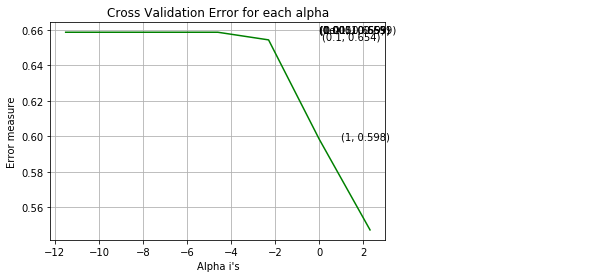

In [53]:

fig, ax = plt.subplots()
ax.plot(np.log(alphas), log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alphas[i],np.round(txt,3)), (alphas[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


### training Logistic Regression with best alpha

In [54]:
best_alpha = alphas[np.argmin(log_error_array)]

clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(train_X, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_X, train_y)


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=10, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                              

For values of best alpha =  10 The train log loss is: 0.5464636857321303
For values of best alpha =  10 The test log loss is: 0.5539907537916293
Total number of data points : 121287


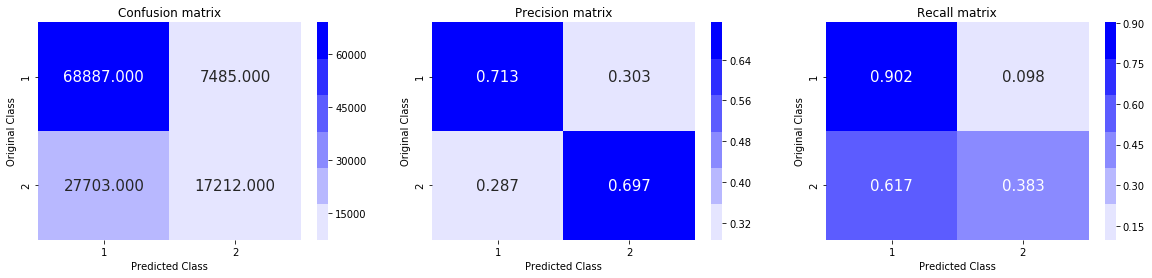

In [56]:
predict_y = sig_clf.predict_proba(train_X)
print('For values of best alpha = ', best_alpha, "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_X)
print('For values of best alpha = ', best_alpha, "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(test_y, predicted_y)

## SVM

In [59]:
alphas = [10 ** x for x in range(-5, 2)]
log_error_array=[]
for alpha in alphas:
    clf = SGDClassifier(alpha=alpha, penalty='l1', loss='hinge', random_state=42)
    clf.fit(train_X, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_X, train_y)
    predict_y = sig_clf.predict_proba(cv_X)
    
    log_error_array.append(log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))
    
    print('For values of alpha = ', alpha, "The log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 0.6585903042776905
For values of alpha =  0.0001 The log loss is: 0.6585903042776905
For values of alpha =  0.001 The log loss is: 0.6585903042776905
For values of alpha =  0.01 The log loss is: 0.5859935211713677
For values of alpha =  0.1 The log loss is: 0.5866039486110931
For values of alpha =  1 The log loss is: 0.6541725242766979
For values of alpha =  10 The log loss is: 0.6524150300847363


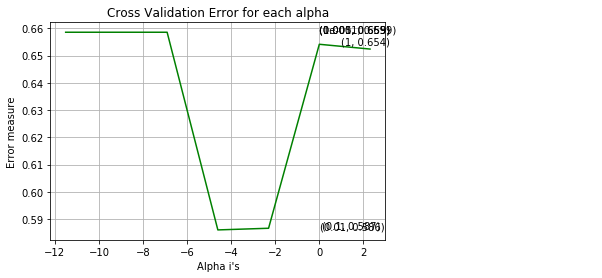

In [60]:

fig, ax = plt.subplots()
ax.plot(np.log(alphas), log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alphas[i],np.round(txt,3)), (alphas[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


### training SVM with best alpha

In [65]:
best_alpha = alphas[np.argmin(log_error_array)]

clf = SGDClassifier(alpha=best_alpha, penalty='l1', loss='hinge', random_state=42)
clf.fit(train_X, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_X, train_y)


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.01, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='hinge', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l1',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                          

For values of best alpha =  0.01 The train log loss is: 0.5671898176355835
For values of best alpha =  0.01 The test log loss is: 0.582691692534217
Total number of data points : 121287


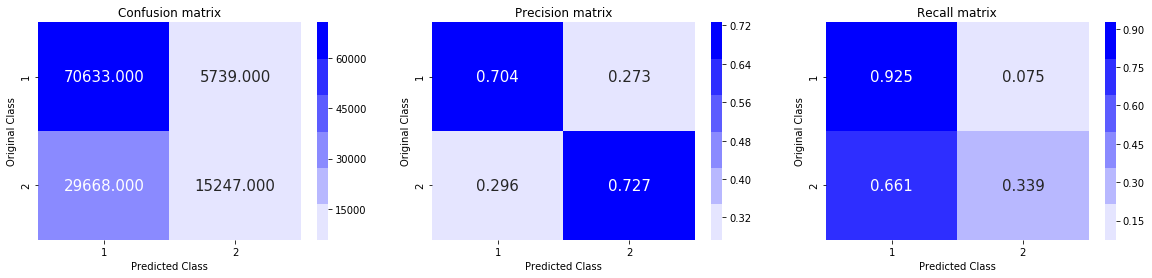

In [66]:
predict_y = sig_clf.predict_proba(train_X)
print('For values of best alpha = ', best_alpha, "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_X)
print('For values of best alpha = ', best_alpha, "The test log loss is:",log_loss(test_y, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(test_y, predicted_y)

## XGBoost

In [6]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'n_estimators': [100, 300, 500],
        'max_depth': [3, 4, 5]
        }

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)

clf = xgb.XGBClassifier(
    learning_rate=0.02, 
    n_estimators=600, 
    objective='binary:logistic',
    silent=True, 
    nthread=1
)

random_search = RandomizedSearchCV(
    clf, 
    param_distributions=params, 
    n_iter=5, 
    scoring='neg_log_loss', 
    cv=skf.split(train_X,train_y), 
    verbose=3, 
    random_state=1001 
)

random_search.fit(train_X, train_y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_estimators=300, min_child_weight=1, max_depth=5 ...............
[CV]  n_estimators=300, min_child_weight=1, max_depth=5, score=-0.375, total=55.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 55.4min remaining:    0.0s


[CV] n_estimators=300, min_child_weight=1, max_depth=5 ...............
[CV]  n_estimators=300, min_child_weight=1, max_depth=5, score=-0.380, total=50.6min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 105.9min remaining:    0.0s


[CV] n_estimators=300, min_child_weight=1, max_depth=5 ...............
[CV]  n_estimators=300, min_child_weight=1, max_depth=5, score=-0.377, total=50.4min
[CV] n_estimators=300, min_child_weight=1, max_depth=5 ...............
[CV]  n_estimators=300, min_child_weight=1, max_depth=5, score=-0.379, total=50.4min
[CV] n_estimators=300, min_child_weight=1, max_depth=5 ...............
[CV]  n_estimators=300, min_child_weight=1, max_depth=5, score=-0.382, total=50.4min
[CV] n_estimators=500, min_child_weight=1, max_depth=4 ...............
[CV]  n_estimators=500, min_child_weight=1, max_depth=4, score=-0.372, total=66.8min
[CV] n_estimators=500, min_child_weight=1, max_depth=4 ...............
[CV]  n_estimators=500, min_child_weight=1, max_depth=4, score=-0.377, total=67.1min
[CV] n_estimators=500, min_child_weight=1, max_depth=4 ...............
[CV]  n_estimators=500, min_child_weight=1, max_depth=4, score=-0.373, total=68.7min
[CV] n_estimators=500, min_child_weight=1, max_depth=4 .........

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 1123.5min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x00000225BACFDEB8>,
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=600,
                                           n_jobs=1, nthread=1,
                                           obje...',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=True, subsample=1,
             

In [7]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)

In [8]:
xgb_clf = xgb.XGBClassifier(
    learning_rate=0.02, 
    n_estimators=500, 
    max_depth=4,
    min_child_weight=1,
    objective='binary:logistic',
    silent=True, 
    nthread=1,    
)

xgb_clf.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)

In [9]:
sig_clf = CalibratedClassifierCV(xgb_clf, method="sigmoid")
sig_clf.fit(train_X, train_y)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=1, gamma=0,
                                                    learning_rate=0.02,
                                                    max_delta_step=0,
                                                    max_depth=4,
                                                    min_child_weight=1,
                                                    missing=None,
                                                    n_estimators=500, n_jobs=1,
                                                    nthread=1,
                                                    objective='binary:logistic',
                                                    random_state=0,

In [10]:
predict_y = sig_clf.predict_proba(test_X)
print("The test log loss is:",log_loss(test_y, predict_y, labels=xgb_clf.classes_, eps=1e-15))

The test log loss is: 0.40530914447517785


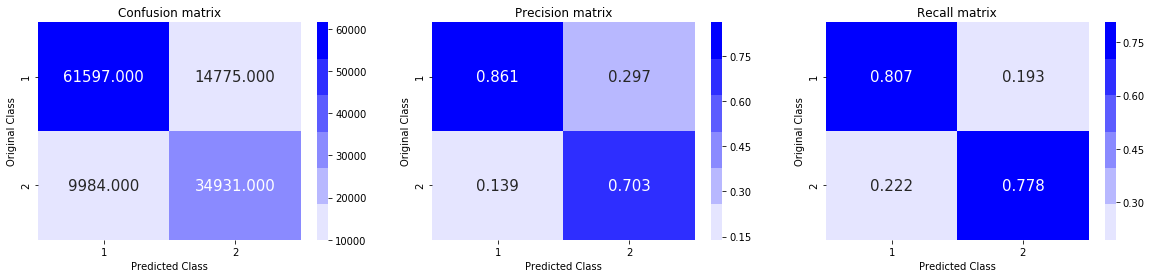

In [11]:
predicted_y = np.argmax(predict_y, axis=1)
plot_confusion_matrix(test_y, predicted_y)

## Summary

In [12]:
table = PrettyTable()
table.field_names = ['Model', 'Loss']
table.add_row(['Random', '0.8838083513668935'])
table.add_row(['Logistic Regression', '0.5539907537916293'])
table.add_row(['SVM',' 0.582691692534217'])
table.add_row(['XGBoost', ' 0.40530914447517785'])
print(table)

+---------------------+----------------------+
|        Model        |         Loss         |
+---------------------+----------------------+
|        Random       |  0.8838083513668935  |
| Logistic Regression |  0.5539907537916293  |
|         SVM         |   0.582691692534217  |
|       XGBoost       |  0.40530914447517785 |
+---------------------+----------------------+


## Observation:
- Using avg w2v as text featurization, XGBoost is performing better than others as it give lowest log loss of 0.405